# EE782 Assignment 2 : 

# Shounak Das (21D070068) and Varunav Singh (21D070086) 




In [1]:
import warnings
warnings.filterwarnings("ignore")
import time
import pyttsx3
import requests
import winsound
import keyboard  
from inputimeout import inputimeout, TimeoutOccurred
import getpass
from gtts import gTTS
import os
from playsound3 import playsound
import sys
import sounddevice as sd
import numpy as np
import whisper
import torch
import pyttsx3
from speechbrain.pretrained import SpeakerRecognition
from scipy.io.wavfile import write
from IPython.display import display, clear_output
import cv2
from PIL import Image
from IPython.display import display, clear_output
import time
import cv2
import face_recognition
from datetime import datetime



In [2]:
def speak(text):
    tts = gTTS(text=text, lang='en')
    tts.save("temp.mp3")
    playsound("temp.mp3")
    os.remove("temp.mp3")


In [3]:
def escalation_dialogue(count , engine=pyttsx3.init()):

    # --- Escalation logic ---
    if count == 1:
        base_text = "Please Identify yourself via password."
    elif count == 2:
        base_text = "Password not recognized. Please leave or tell me the password. This room is being monitored."
    elif count >= 3:
        base_text = "Security alert triggered! This is your last attempt to tell the password. If you don't know the password, leave immediately!"
    else:
        base_text = "System idle."

    # --- Gemini API setup ---
    API_KEY = "GEMINI_API_KEY"
    url = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent"
    headers = {
        "x-goog-api-key": API_KEY,
        "Content-Type": "application/json"
    }

    body = {
        "contents": [
            {
                "role": "user",
                "parts": [
                    {
                        "text": (
                            f"You are a Security Guard guarding a room. Paraphrase and give a response akin to '{base_text}' politely yet firmly without changing the meaning or omitting any information. The response must be a single line of plain text only, containing no introductory phrases, formatting characters (like * or **), or parenthetical actions." 
                        )
                    }
                ]
            }
        ]
    }

    max_retries = 3
    retry_delay = 3  # fixed delay between retries (seconds)
    
    for attempt in range(1,  4):
        try:
            resp = requests.post(url, headers=headers, json=body, timeout=15)
            if resp.status_code == 200:
                data = resp.json()
                llm_reply = data["candidates"][0]["content"]["parts"][0]["text"]
                break
            elif resp.status_code == 429:
                print(f"[Attempt {attempt}] Rate limit hit. Retrying in {3}s...")
                time.sleep(3)
            else:
                print(f"[Attempt {attempt}] Error {resp.status_code}: {resp.text}")
                time.sleep(3)
        except requests.exceptions.RequestException as e:
            print(f"⚠️ [Attempt {attempt}] Network error: {e}")
            time.sleep(3)
    else:
        llm_reply = base_text + " (System offline — using fallback message.)"
    
    print("Gemini response:", llm_reply)
    speak( llm_reply )
    audio = record(duration=5)  # shorter duration for password
    print("🧠 Processing speech for password...")
    result = model.transcribe(audio, fp16=False, language='en')
    spoken_text = result["text"].strip().lower()
    print(f"🗣️ You said: {spoken_text}")

    if "pineapple" in spoken_text:
        return True
    else:
        return False


In [4]:
SAMPLE_RATE = 16000  # Whisper expects 16kHz audio
DURATION = 5         # seconds of audio to record
PHRASE = "guard my room"
# Initialize text-to-speech engine
engine = pyttsx3.init()
engine.setProperty('rate', 175)  # speech speed
engine.setProperty('volume', 1.0)  # max volume

device = "cuda" if torch.cuda.is_available() else "cpu"
model = whisper.load_model("small", device=device)
recognizer = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

guard_mode = False

def record(duration=DURATION, sample_rate=SAMPLE_RATE):
    print("🎧 Listening...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype=np.float32)
    sd.wait()
    return np.squeeze(audio)

In [6]:
# MAIN LOOP
while not guard_mode:
    audio = record()

    # Transcribe with Whisper
    print(" Processing speech...")
    result = model.transcribe(audio, fp16=False, language='en')
    text = result["text"].strip().lower()
    print(f"🗣️ You said: {text}")

    # Check for activation phrase
    if PHRASE in text:
        guard_mode = True
        print("\n Guard mode activated.")            
        speak("Guard mode activated.")

print("🛡️ System is now in Guard Mode.")


# ---------- SETUP ----------
# Folder containing trusted people's images
TRUSTED_DIR = "trusted_faces"

known_face_encodings = []
known_face_names = []

print("Enrolling trusted faces...")

# Load and encode all trusted faces
for file_name in os.listdir(TRUSTED_DIR):
    if file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        path = os.path.join(TRUSTED_DIR, file_name)
        image = face_recognition.load_image_file(path)
        encodings = face_recognition.face_encodings(image)
        if len(encodings) > 0:
            known_face_encodings.append(encodings[0])
            known_face_names.append(os.path.splitext(file_name)[0])
            print(f"  ✓ Added {file_name}")
        else:
            print(f"  ⚠️ No face detected in {file_name}")

print(f"Total enrolled: {len(known_face_names)} trusted faces")

# ---------- GUARD MODE ----------
print("Starting Guard Mode Started")
video_capture = cv2.VideoCapture(0)

counter = 1
while True:

    ret, frame = video_capture.read()
    if not ret:
        print("[ERROR] Unable to access webcam.")
        break

    # Resize frame for faster processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)

    # Detect faces and get encodings
    face_locations = face_recognition.face_locations(rgb_small_frame)
    face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

    face_names = []
    
    for face_encoding in face_encodings:
        # Compare with known faces
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = "Unknown"

        # Compute similarity (lower distance = better match)
        face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
        if len(face_distances) > 0:
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]
        name=name.replace("_","")
        face_names.append(name)

    # ---------- FACE TRANSFORMATIONS ----------

    for (top, right, bottom, left), name in zip(face_locations, face_names):
        # Scale back up face locations since we resized frame
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        color = (0, 255, 0) if name != "Unknown" else (0, 0, 255)
        cv2.rectangle(frame, (left, top), (right, bottom), color, 2)
        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), color, cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 6, bottom - 6), font, 0.8, (255, 255, 255), 1)
        # Log recognition events
        if name != "Unknown":
            speak(f"Welcome back {name}")
            print(f"Welcome back {name}")
            counter = 1
            raise RuntimeError("Guard Mode Terminated")

            
        else:
            while (counter<=3):    
                if (escalation_dialogue(counter,engine=engine)):
                    print("Password recognized")
                    speak("password recognized")
                    raise RuntimeError("Guard Mode Terminated")
                else:
                    counter+=1
        break

video_capture.release()
cv2.destroyAllWindows()
print(  "Guard mode terminated." )



🛡️ System is now in Guard Mode.
Enrolling trusted faces...
  ⚠️ No face detected in varunav.jpg
  ✓ Added varunav_.jpg
  ✓ Added varunav__.jpg
  ✓ Added varunav___.jpg
Total enrolled: 3 trusted faces
Starting Guard Mode Started
Gemini response: Your password is required for identity verification, please.
🎧 Listening...
🧠 Processing speech for password...
🗣️ You said: password here, so i will not tell the password correctly the first time let's say
Gemini response: That's not the correct password. You must provide the right one or vacate the premises, as this area is under surveillance.
🎧 Listening...
🧠 Processing speech for password...
🗣️ You said: so again this time also i can avoid seeing the password because again
Gemini response: A security protocol is now active; this is your final opportunity to provide the correct password, otherwise, you must vacate the premises at once.
🎧 Listening...
🧠 Processing speech for password...
🗣️ You said: pineapple
Password recognized


RuntimeError: Guard Mode Terminated

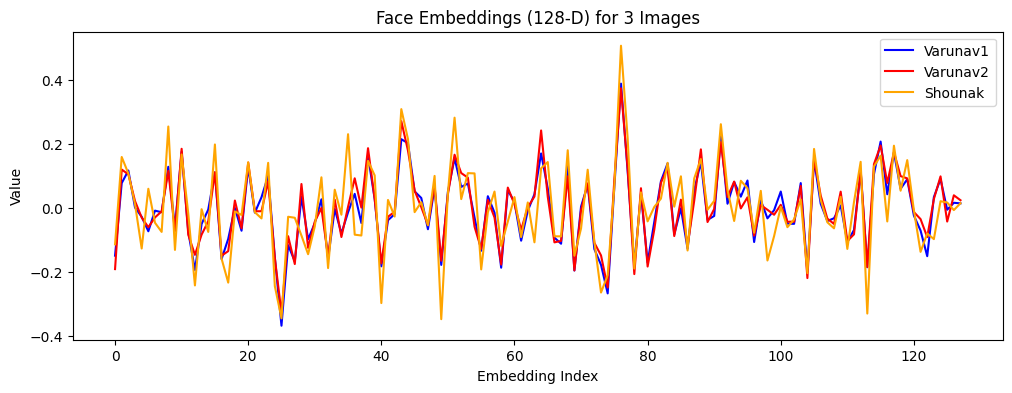

In [27]:
import face_recognition
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Image paths ---
image1_path = os.path.join("trusted_faces", "varunav___.jpg")
image2_path = os.path.join("trusted_faces", "varunav_.jpg")
image3_path = "shounak.jpg"

# --- Load images ---
img1 = face_recognition.load_image_file(image1_path)
img2 = face_recognition.load_image_file(image2_path)
img3 = face_recognition.load_image_file(image3_path)

# --- Detect faces and get embeddings ---
encodings1 = face_recognition.face_encodings(img1, face_recognition.face_locations(img1))
encodings2 = face_recognition.face_encodings(img2, face_recognition.face_locations(img2))
encodings3 = face_recognition.face_encodings(img3, face_recognition.face_locations(img3))

if len(encodings1) == 0 or len(encodings2) == 0 or len(encodings3) == 0:
    print("[ERROR] No face detected in one of the images.")
    exit()

all_encodings = np.vstack([encodings1, encodings2, encodings3])
labels = ["Varunav1"] * len(encodings1) + ["Varunav2"] * len(encodings2) + ["Shounak"] * len(encodings3)

# --- Assign colors ---
colors = ["blue"] * len(encodings1) + ["red"] * len(encodings2) + ["orange"] * len(encodings3)

# --- Visualize embeddings as 128-D lines with colors ---
plt.figure(figsize=(12, 4))
for i, encoding in enumerate(all_encodings):
    plt.plot(encoding, label=labels[i], color=colors[i])
plt.title("Face Embeddings (128-D) for 3 Images")
plt.xlabel("Embedding Index")
plt.ylabel("Value")
plt.legend()
plt.show()


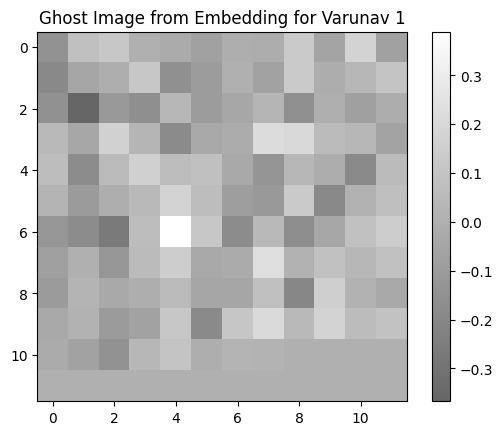

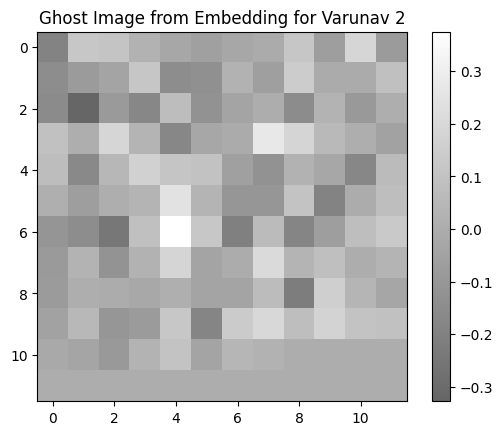

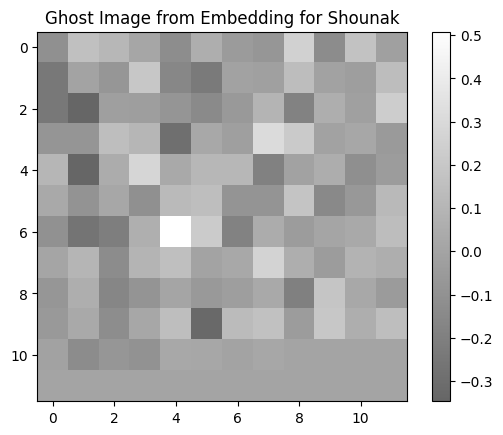

In [28]:
import matplotlib.pyplot as plt
import numpy as np

embedding = all_encodings[0]  # 128-D

# Reshape to a square-ish grid for visualization
grid_size = int(np.ceil(np.sqrt(len(embedding))))
grid = np.zeros((grid_size, grid_size))
grid.flat[:len(embedding)] = embedding

plt.imshow(grid, cmap='gray', alpha=0.6)  # ghostly translucent
plt.title("Ghost Image from Embedding for Varunav 1")
plt.colorbar()
plt.show()

embedding = all_encodings[1]  # 128-D

# Reshape to a square-ish grid for visualization
grid_size = int(np.ceil(np.sqrt(len(embedding))))
grid = np.zeros((grid_size, grid_size))
grid.flat[:len(embedding)] = embedding

plt.imshow(grid, cmap='gray', alpha=0.6)  # ghostly translucent
plt.title("Ghost Image from Embedding for Varunav 2")
plt.colorbar()
plt.show()

embedding = all_encodings[2]  # 128-D

# Reshape to a square-ish grid for visualization
grid_size = int(np.ceil(np.sqrt(len(embedding))))
grid = np.zeros((grid_size, grid_size))
grid.flat[:len(embedding)] = embedding

plt.imshow(grid, cmap='gray', alpha=0.6)  # ghostly translucent
plt.title("Ghost Image from Embedding for Shounak")
plt.colorbar()
plt.show()



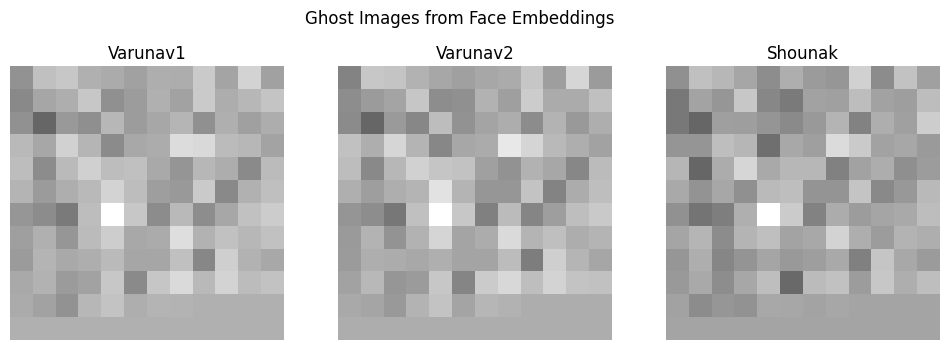

Pairwise SSIM and MSE:
Varunav1 vs Varunav2 -> SSIM: 0.9765, MSE: 0.0013
Varunav1 vs Shounak -> SSIM: 0.8773, MSE: 0.0116
Varunav2 vs Shounak -> SSIM: 0.8593, MSE: 0.0110


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from itertools import combinations

# --- Function to convert 128-D embedding to square ghost image ---
def embedding_to_ghost(embedding, grid_size=None):
    if grid_size is None:
        grid_size = int(np.ceil(np.sqrt(len(embedding))))
    grid = np.zeros((grid_size, grid_size))
    grid.flat[:len(embedding)] = embedding
    # Normalize for visualization
    grid = (grid - grid.min()) / (grid.max() - grid.min())
    return grid

# --- Generate ghost images for all embeddings ---
ghost_images = [embedding_to_ghost(enc) for enc in all_encodings]

# --- Visualize ghost images ---
plt.figure(figsize=(12,4))
for i, img in enumerate(ghost_images):
    plt.subplot(1, len(ghost_images), i+1)
    plt.imshow(img, cmap='gray', alpha=0.6)
    plt.title(labels[i])
    plt.axis('off')
plt.suptitle("Ghost Images from Face Embeddings")
plt.show()

# --- Compute pairwise SSIM and MSE ---
from skimage.metrics import structural_similarity as ssim
import numpy as np
from itertools import combinations

# --- Compute pairwise SSIM and MSE ---
pairs = list(combinations(range(len(ghost_images)), 2))

print("Pairwise SSIM and MSE:")
for i, j in pairs:
    ghost1, ghost2 = ghost_images[i], ghost_images[j]
    # Resize to same shape if needed
    min_shape = np.minimum(ghost1.shape, ghost2.shape)
    ghost1_crop = ghost1[:min_shape[0], :min_shape[1]]
    ghost2_crop = ghost2[:min_shape[0], :min_shape[1]]
    
    ssim_val = ssim(ghost1_crop, ghost2_crop, data_range=1.0)
    mse_val = np.mean((ghost1_crop - ghost2_crop)**2)
    print(f"{labels[i]} vs {labels[j]} -> SSIM: {ssim_val:.4f}, MSE: {mse_val:.4f}")

